# Практическая работа №4
### Тема: Оптимизация параллельного кода на GPU с использованием различных типов памяти
Задания
1) Подготовка данных:
Реализовать программу для генерации массива случайных чисел
(размер: 1,000,000 элементов).
2) Оптимизация параллельного редукционного алгоритма:
Реализовать редукцию суммы элементов массива с
использованием:
a. Только глобальной памяти.
b. Комбинации глобальной и разделяемой памяти.
Сравнить производительность и объяснить влияние использования
разделяемой памяти.
3) Оптимизация сортировки на GPU:
Реализовать сортировку пузырьком для небольших подмассивов с
использованием локальной памяти.
Использовать глобальную память для хранения общего массива.
Реализовать слияние отсортированных подмассивов с использованием
разделяемой памяти.
4) Измерение производительности:
Замерить время выполнения программ с использованием разных типов
памяти для массивов размером 10,000, 100,000 и 1,000,000 элементов.
Построить графики зависимости времени выполнения от размера
массива.
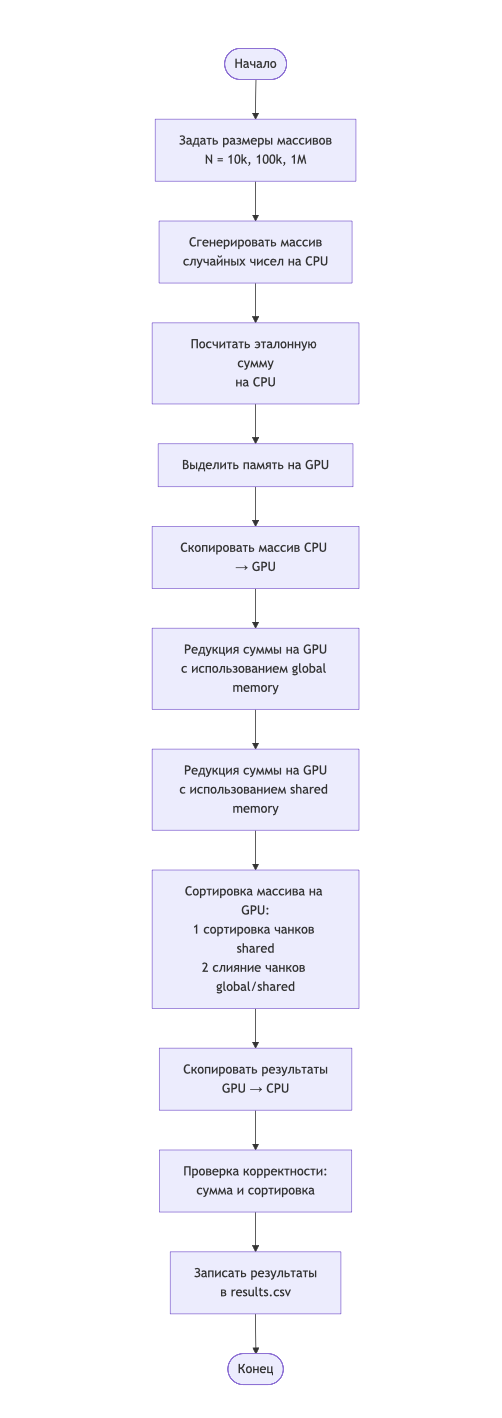

In [ ]:
!nvidia-smi
!nvcc --version

Mon Dec 29 14:56:55 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   59C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
%%writefile main.cu
// main.cu
// Практическая работа №4 (CUDA)
// Global / Shared / Local memory + замеры времени + CSV

#include <cuda_runtime.h>   // CUDA функции
#include <iostream>         // cout/cerr
#include <vector>           // vector
#include <random>           // rand generator
#include <algorithm>        // is_sorted
#include <fstream>          // results.csv
#include <climits>          // INT_MAX

// Проверка ошибок CUDA (чтобы сразу видеть, если что-то пошло не так)
#define CUDA_CHECK(call) do {                                     \
    cudaError_t err = (call);                                     \
    if (err != cudaSuccess) {                                     \
        std::cerr << "CUDA error: " << cudaGetErrorString(err)    \
                  << " at " << __FILE__ << ":" << __LINE__        \
                  << std::endl;                                   \
        exit(1);                                                  \
    }                                                             \
} while(0)

// Таймер на CUDA events
struct GpuTimer {
    cudaEvent_t s, e;                        // события начала и конца
    GpuTimer() {                             // конструктор
        CUDA_CHECK(cudaEventCreate(&s));     // создать start event
        CUDA_CHECK(cudaEventCreate(&e));     // создать stop event
    }
    ~GpuTimer() {                            // деструктор
        cudaEventDestroy(s);                 // удалить start event
        cudaEventDestroy(e);                 // удалить stop event
    }
    void start() {                           // старт таймера
        CUDA_CHECK(cudaEventRecord(s));      // записать событие старта
    }
    float stop() {                           // стоп таймера
        CUDA_CHECK(cudaEventRecord(e));      // записать событие конца
        CUDA_CHECK(cudaEventSynchronize(e)); // дождаться конца
        float ms = 0.0f;                     // переменная времени
        CUDA_CHECK(cudaEventElapsedTime(&ms, s, e)); // посчитать ms
        return ms;                           // вернуть ms
    }
};

// ======================================================
// 2a) Редукция: только GLOBAL memory (atomicAdd)
// ======================================================
__global__ void reduce_global_only_int(const int* in, int* out, int n) {
    int local = 0;                                              // локальная сумма (регистр)
    int tid = blockIdx.x * blockDim.x + threadIdx.x;            // глобальный индекс потока
    int stride = blockDim.x * gridDim.x;                        // шаг по массиву

    for (int i = tid; i < n; i += stride) {                     // каждый поток идёт по своим i
        local += in[i];                                         // суммируем элементы
    }

    atomicAdd(out, local);                                      // атомарно добавляем в общий результат
}

// ======================================================
// 2b) Редукция: GLOBAL + SHARED memory
// ======================================================
__global__ void reduce_shared_blocks(const int* in, long long* blockSums, int n) {
    extern __shared__ long long s_ll[];                         // shared (long long) — имя уникальное!

    long long local = 0;                                        // локальная сумма
    int tid = blockIdx.x * blockDim.x + threadIdx.x;            // глобальный индекс
    int stride = blockDim.x * gridDim.x;                        // шаг

    for (int i = tid; i < n; i += stride) {                     // суммируем элементы
        local += (long long)in[i];                              // приводим к long long
    }

    s_ll[threadIdx.x] = local;                                  // кладём в shared
    __syncthreads();                                            // синхронизация

    for (int step = blockDim.x / 2; step > 0; step >>= 1) {     // редукция внутри shared
        if (threadIdx.x < step) {
            s_ll[threadIdx.x] += s_ll[threadIdx.x + step];      // складываем пары
        }
        __syncthreads();                                        // синхронизация
    }

    if (threadIdx.x == 0) {                                     // один поток
        blockSums[blockIdx.x] = s_ll[0];                        // пишет сумму блока
    }
}

// ======================================================
// 3) Сортировка чанка: Odd-Even Sort в SHARED
// ======================================================
__global__ void odd_even_sort_chunks_shared(int* data, int n, int chunk) {
    extern __shared__ int s_i[];                                // shared (int) — другое имя!

    int start = blockIdx.x * chunk;                             // начало чанка
    int idx = start + threadIdx.x;                              // индекс элемента в массиве
    int t = threadIdx.x;                                        // индекс в блоке

    if (t < chunk) {                                            // загрузка чанка
        s_i[t] = (idx < n) ? data[idx] : INT_MAX;               // если вышли за n, ставим INT_MAX
    }
    __syncthreads();                                            // ждём, пока все загрузят

    for (int phase = 0; phase < chunk; phase++) {               // делаем chunk фаз
        int i = (phase % 2 == 0) ? (2 * t) : (2 * t + 1);        // чётная/нечётная фаза
        if (i + 1 < chunk) {                                    // проверяем границы
            int a = s_i[i];                                     // локально (регистр)
            int b = s_i[i + 1];                                 // локально (регистр)
            if (a > b) {                                        // swap если неправильно
                s_i[i] = b;
                s_i[i + 1] = a;
            }
        }
        __syncthreads();                                        // синхронизация между фазами
    }

    if (t < chunk && idx < n) {                                 // запись назад
        data[idx] = s_i[t];
    }
}

// ======================================================
// Merge pass: слияние двух отсортированных кусков
// ======================================================
__global__ void merge_pass(const int* in, int* out, int n, int runSize) {
    extern __shared__ int s_merge[];                            // shared для merge (ещё одно имя)

    int pairStart = blockIdx.x * (2 * runSize);                 // начало пары
    int L = pairStart;                                          // левый старт
    int M = min(pairStart + runSize, n);                        // середина
    int R = min(pairStart + 2 * runSize, n);                    // правый конец

    if (L >= n) return;                                         // если вышли за массив — выходим

    if (M >= R) {                                               // если правой части нет — копируем
        for (int i = L + threadIdx.x; i < R; i += blockDim.x) {
            out[i] = in[i];
        }
        return;
    }

    int total = R - L;                                          // сколько элементов в диапазоне
    int sharedCap = blockDim.x * 8;                             // сколько примерно влезает в shared

    if (total <= sharedCap) {                                   // маленький диапазон — через shared
        for (int i = threadIdx.x; i < total; i += blockDim.x) {
            s_merge[i] = in[L + i];
        }
        __syncthreads();

        if (threadIdx.x == 0) {                                 // один поток делает merge
            int i = 0;
            int j = M - L;
            int leftEnd = M - L;
            int rightEnd = R - L;

            for (int k = L; k < R; k++) {
                if (i >= leftEnd) out[k] = s_merge[j++];        // левая кончилась
                else if (j >= rightEnd) out[k] = s_merge[i++];  // правая кончилась
                else out[k] = (s_merge[i] <= s_merge[j]) ? s_merge[i++] : s_merge[j++];
            }
        }
    } else {                                                    // большой диапазон — из global
        if (threadIdx.x == 0) {
            int i = L, j = M;
            for (int k = L; k < R; k++) {
                if (i >= M) out[k] = in[j++];
                else if (j >= R) out[k] = in[i++];
                else out[k] = (in[i] <= in[j]) ? in[i++] : in[j++];
            }
        }
    }
}

// CPU сумма для проверки (эталон)
long long cpu_sum(const std::vector<int>& a) {
    long long s = 0;                                            // сумма
    for (int x : a) s += x;                                     // складываем
    return s;                                                   // возвращаем
}

int main() {
    std::vector<int> Ns = {10000, 100000, 1000000};             // размеры массивов

    const int BLOCK = 256;                                      // потоков в блоке
    const int MAX_GRID = 2048;                                  // ограничим число блоков

    const int WARMUP = 2;                                       // прогрев
    const int REPEATS = 10;                                     // усреднение

    std::ofstream csv("results.csv");                           // открываем CSV
    csv << "N,reduce_global_ms,reduce_shared_ms,sort_ms,ok_global,ok_shared,ok_sort\n";
    std::cout << "N,reduce_global_ms,reduce_shared_ms,sort_ms,ok_global,ok_shared,ok_sort\n";

    std::mt19937 rng(123);                                      // генератор
    std::uniform_int_distribution<int> dist(0, 100);            // значения 0..100

    for (int N : Ns) {
        // ---------- генерируем массив на CPU ----------
        std::vector<int> h(N);                                  // массив на CPU
        for (int i = 0; i < N; i++) h[i] = dist(rng);           // заполняем
        long long ref = cpu_sum(h);                              // эталонная сумма

        // ---------- копируем массив на GPU ----------
        int* d_in = nullptr;                                    // массив на GPU
        CUDA_CHECK(cudaMalloc(&d_in, (size_t)N * sizeof(int)));  // выделяем память
        CUDA_CHECK(cudaMemcpy(d_in, h.data(),
                              (size_t)N * sizeof(int),
                              cudaMemcpyHostToDevice));         // копируем

        int grid = (N + BLOCK - 1) / BLOCK;                     // число блоков
        if (grid > MAX_GRID) grid = MAX_GRID;                   // ограничим

        // ======================================================
        // 2a) global-only reduction
        // ======================================================
        int* d_sum_int = nullptr;                               // сумма на GPU
        CUDA_CHECK(cudaMalloc(&d_sum_int, sizeof(int)));         // выделяем память

        for (int w = 0; w < WARMUP; w++) {                      // прогрев
            CUDA_CHECK(cudaMemset(d_sum_int, 0, sizeof(int)));   // обнуляем
            reduce_global_only_int<<<grid, BLOCK>>>(d_in, d_sum_int, N); // запуск ядра
        }
        CUDA_CHECK(cudaDeviceSynchronize());                    // ждём

        float ms_global = 0.0f;                                 // время
        {
            GpuTimer t;                                         // таймер
            t.start();                                          // старт
            for (int r = 0; r < REPEATS; r++) {                 // несколько повторов
                CUDA_CHECK(cudaMemset(d_sum_int, 0, sizeof(int)));
                reduce_global_only_int<<<grid, BLOCK>>>(d_in, d_sum_int, N);
            }
            CUDA_CHECK(cudaDeviceSynchronize());
            ms_global = t.stop() / REPEATS;                     // среднее время
        }

        int sumA_int = 0;                                       // результат суммы
        CUDA_CHECK(cudaMemcpy(&sumA_int, d_sum_int,
                              sizeof(int),
                              cudaMemcpyDeviceToHost));         // копируем на CPU
        bool okA = ((long long)sumA_int == ref);                // проверка

        // ======================================================
        // 2b) shared reduction
        // ======================================================
        long long* d_blockSums = nullptr;                       // массив сумм блоков
        CUDA_CHECK(cudaMalloc(&d_blockSums,
                              (size_t)grid * sizeof(long long)));

        for (int w = 0; w < WARMUP; w++) {                      // прогрев
            reduce_shared_blocks<<<grid, BLOCK,
                (size_t)BLOCK * sizeof(long long)>>>(d_in, d_blockSums, N);
        }
        CUDA_CHECK(cudaDeviceSynchronize());

        float ms_shared = 0.0f;
        {
            GpuTimer t;
            t.start();
            for (int r = 0; r < REPEATS; r++) {
                reduce_shared_blocks<<<grid, BLOCK,
                    (size_t)BLOCK * sizeof(long long)>>>(d_in, d_blockSums, N);
            }
            CUDA_CHECK(cudaDeviceSynchronize());
            ms_shared = t.stop() / REPEATS;
        }

        std::vector<long long> h_blockSums(grid);               // суммы блоков на CPU
        CUDA_CHECK(cudaMemcpy(h_blockSums.data(), d_blockSums,
                              (size_t)grid * sizeof(long long),
                              cudaMemcpyDeviceToHost));

        long long sumB = 0;                                     // итоговая сумма
        for (auto v : h_blockSums) sumB += v;                   // складываем
        bool okB = (sumB == ref);                               // проверка

        // ======================================================
        // 3) sorting
        // ======================================================
        CUDA_CHECK(cudaMemcpy(d_in, h.data(),
                              (size_t)N * sizeof(int),
                              cudaMemcpyHostToDevice));         // возвращаем исходный массив

        int* d_tmp = nullptr;                                   // временный массив
        CUDA_CHECK(cudaMalloc(&d_tmp, (size_t)N * sizeof(int))); // выделяем

        int chunk = 256;                                        // размер чанка
        int numChunks = (N + chunk - 1) / chunk;                // сколько чанков

        // прогрев сортировки
        for (int w = 0; w < WARMUP; w++) {
            odd_even_sort_chunks_shared<<<numChunks, 256,
                (size_t)chunk * sizeof(int)>>>(d_in, N, chunk);

            int* src = d_in;                                    // источник
            int* dst = d_tmp;                                   // приёмник

            for (int run = chunk; run < N; run *= 2) {          // этапы merge
                int pairs = (N + 2 * run - 1) / (2 * run);       // сколько пар
                int threads = 128;                              // потоков на блок
                size_t shmem = (size_t)(threads * 8) * sizeof(int); // shared для merge
                merge_pass<<<pairs, threads, shmem>>>(src, dst, N, run);
                std::swap(src, dst);                            // меняем местами
            }

            if (src != d_in) {                                  // если итог не в d_in
                CUDA_CHECK(cudaMemcpy(d_in, src,
                                      (size_t)N * sizeof(int),
                                      cudaMemcpyDeviceToDevice));
            }
        }
        CUDA_CHECK(cudaDeviceSynchronize());

        float ms_sort = 0.0f;                                   // время сортировки
        {
            GpuTimer t;
            t.start();

            odd_even_sort_chunks_shared<<<numChunks, 256,
                (size_t)chunk * sizeof(int)>>>(d_in, N, chunk);

            int* src = d_in;
            int* dst = d_tmp;

            for (int run = chunk; run < N; run *= 2) {
                int pairs = (N + 2 * run - 1) / (2 * run);
                int threads = 128;
                size_t shmem = (size_t)(threads * 8) * sizeof(int);
                merge_pass<<<pairs, threads, shmem>>>(src, dst, N, run);
                std::swap(src, dst);
            }

            if (src != d_in) {
                CUDA_CHECK(cudaMemcpy(d_in, src,
                                      (size_t)N * sizeof(int),
                                      cudaMemcpyDeviceToDevice));
            }

            CUDA_CHECK(cudaDeviceSynchronize());
            ms_sort = t.stop();
        }

        // проверяем сортировку
        std::vector<int> h_sorted(N);                           // массив для проверки
        CUDA_CHECK(cudaMemcpy(h_sorted.data(), d_in,
                              (size_t)N * sizeof(int),
                              cudaMemcpyDeviceToHost));
        bool okSort = std::is_sorted(h_sorted.begin(), h_sorted.end()); // проверка

        // вывод результатов
        csv << N << "," << ms_global << "," << ms_shared << "," << ms_sort
            << "," << (okA ? 1 : 0) << "," << (okB ? 1 : 0) << "," << (okSort ? 1 : 0) << "\n";

        std::cout << N << "," << ms_global << "," << ms_shared << "," << ms_sort
                  << "," << (okA ? 1 : 0) << "," << (okB ? 1 : 0) << "," << (okSort ? 1 : 0) << "\n";

        // освобождаем память
        cudaFree(d_tmp);
        cudaFree(d_blockSums);
        cudaFree(d_sum_int);
        cudaFree(d_in);
    }

    csv.close();                                                // закрываем CSV
    std::cerr << "Saved: results.csv\n";                        // сообщение
    return 0;                                                   // конец
}





Overwriting main.cu


In [ ]:
!nvcc -O3 -arch=sm_75 main.cu -o main
!./main
!cat results.csv

N,reduce_global_ms,reduce_shared_ms,sort_ms,ok_global,ok_shared,ok_sort
10000,0.0063712,0.006368,6.45978,1,1,1
100000,0.0111584,0.0157696,55.6442,1,1,1
1000000,0.03416,0.063648,201.592,1,1,1
Saved: results.csv
N,reduce_global_ms,reduce_shared_ms,sort_ms,ok_global,ok_shared,ok_sort
10000,0.0063712,0.006368,6.45978,1,1,1
100000,0.0111584,0.0157696,55.6442,1,1,1
1000000,0.03416,0.063648,201.592,1,1,1


### Вывод

Результаты показали, что при небольших размерах данных разница между использованием глобальной и разделяемой памяти для редукции незначительна из-за накладных расходов. Сортировка занимает основную часть времени выполнения, что связано с выбранным алгоритмом и его вычислительной сложностью. Использование разделяемой памяти позволило сократить количество обращений к глобальной памяти.

# Контрольные вопросы
1. Чем отличаются типы памяти в CUDA и когда их использовать?

  В CUDA есть несколько типов памяти. Регистры самые быстрые, но доступны только одному потоку и используются для временных переменных. Разделяемая память быстрая и общая для потоков одного блока, её используют для промежуточных вычислений. Глобальная память самая медленная, но в ней хранятся большие массивы данных, доступные всем потокам.

2. Как использование разделяемой памяти влияет на производительность?

  Разделяемая память работает быстрее глобальной, поэтому если данные сначала загрузить в неё, программа обычно выполняется быстрее. Это позволяет уменьшить количество обращений к глобальной памяти. Однако размер shared памяти ограничен, и требуется синхронизация потоков.

3. Что такое согласованный доступ и как его обеспечить?

Согласованный доступ означает, что потоки читают или записывают данные по соседним адресам памяти. Это достигается простой линейной индексацией через threadIdx и blockIdx. Такой доступ выполняется быстрее, чем случайный.

4. Какие сложности возникают при работе с большим объёмом данных на GPU?

Может не хватить памяти видеокарты, а копирование данных между CPU и GPU занимает время. Также при большом объёме данных важно правильно организовать доступ к памяти, иначе производительность сильно падает.

5. Почему важно минимизировать доступ к глобальной памяти?

Потому что глобальная память работает медленно. Если часто к ней обращаться, программа выполняется дольше. Поэтому стараются использовать регистры и разделяемую память.

6. Как использовать профилирование для анализа производительности CUDA-программ?

Можно измерять время выполнения с помощью cudaEvent, а также использовать инструменты NVIDIA, такие как Nsight. Профилирование помогает понять, где программа тормозит и что нужно оптимизировать.